<a href="https://colab.research.google.com/github/mauriciodev/braz_iono_series/blob/main/braz_iono_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2022 Mauricio Carvalho Mathias de Paulo and Danilo 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Libraries

In [2]:
from datetime import datetime
import pandas as pd
import urllib
import os
from zipfile import ZipFile
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import re
import io
import urllib.request
import scipy
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

## Downloading data

In [3]:
start_doy = 1
end_doy = 365
end_year=2019
start_year=2013
#year=2019
output_folder = "MyDrive/0braz"
station="braz"
#We recommend running the code one year at a time, because the servers might disable long download sequences.

In [4]:
#from google.colab import drive
mount_folder = "/mnt/ext4/mauricio/artigos/braz_iono_series/"
#drive.mount(mount_folder)
folder = os.path.join(mount_folder,output_folder)
os.makedirs(folder,exist_ok=True)
os.chdir(folder)

In [5]:
print(folder)

/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz


# Baixar os programas de conversão e limpeza do rinex

In [6]:
if not os.path.exists("crx2rnx"):
  !wget https://terras.gsi.go.jp/ja/crx2rnx/RNXCMP_4.1.0_src.tar.gz
  !tar -xzvf RNXCMP_4.1.0_src.tar.gz
  !gcc ./RNXCMP_4.1.0_src/source/crx2rnx.c -o crx2rnx
if not os.path.exists("teqc"):
  !wget https://www.unavco.org/software/data-processing/teqc/development/teqc_CentOSLx86_64s.zip -O teqc.zip
  !unzip -o teqc.zip 

# Baixar os arquivos rinex e executar a limpeza dos arquivos

In [7]:
for year in range (start_year,end_year+1):
  for doy in range (start_doy,end_doy+1+(0 if year%4!=0 else 1)):
    link="""https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/{2}/{0:03}/{1}{0:03}1.zip""".format(doy,station,year)
    rbmcfile=link.split("/")[-1]
    print(link)
    zipFile=str(year)+rbmcfile
    if not os.path.exists(zipFile) or os.path.getsize(zipFile)<1024:
      !wget "$link" -O $zipFile
      !chmod 777 crx2rnx teqc 
      !unzip -o $zipFile 
      crxfile=rbmcfile.replace(".zip",'.{}d'.format(year%100))
      if os.path.exists(crxfile):
          !./crx2rnx -f $crxfile
      #print("Output file should be {}. Please check the Files tab.".format("rjni2361.21d"[:-1]+"o"))
      rnx2file=crxfile[:-1]+"o"
      newFile=rnx2file.replace(".","gps.")
      !./teqc -E -C -R -S -O.obs L1L2C1P2S1S2 +out $newFile $rnx2file 
      print("RINEX 2 file saved to {}".format(newFile))
      #Let's fix the lack of wavelength factor
      !sed '/^.*APPROX POSITION XYZ.*/a \     1     1                                                WAVELENGTH FACT L1\/2' -i $newFile
    else:
      print("File exists {}".format(zipFile))

https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/001/braz0011.zip
File exists 2013braz0011.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/002/braz0021.zip
File exists 2013braz0021.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/003/braz0031.zip
File exists 2013braz0031.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/004/braz0041.zip
File exists 2013braz0041.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/005/braz0051.zip
File exists 2013braz0051.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/006/braz0061.zip
File exists 2013braz0061.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/007/braz0071.zip
File exists 2013braz0071.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/d

Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:08 ERROR 404: Not Found.

Archive:  2013braz2091.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2013braz2091.zip or
        2013braz2091.zip.zip, and cannot find 2013braz2091.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz2091.13o' in r(ead) mode ... exiting
RINEX 2 file saved to braz2091gps.13o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/210/braz2101.zip
File exists 2013braz2101.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodes

Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:09 ERROR 404: Not Found.

Archive:  2013braz2981.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2013braz2981.zip or
        2013braz2981.zip.zip, and cannot find 2013braz2981.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz2981.13o' in r(ead) mode ... exiting
RINEX 2 file saved to braz2981gps.13o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/299/braz2991.zip
--2022-07-20 21:51:09--  https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2013/299/braz2991.zip
Resolving geoftp.ibge.gov.br (geoft

Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:11 ERROR 404: Not Found.

Archive:  2014braz2961.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2014braz2961.zip or
        2014braz2961.zip.zip, and cannot find 2014braz2961.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz2961.14o' in r(ead) mode ... exiting
RINEX 2 file saved to braz2961gps.14o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2014/297/braz2971.zip
File exists 2014braz2971.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodes

Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:12 ERROR 404: Not Found.

Archive:  2015braz0241.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2015braz0241.zip or
        2015braz0241.zip.zip, and cannot find 2015braz0241.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz0241.15o' in r(ead) mode ... exiting
RINEX 2 file saved to braz0241gps.15o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/025/braz0251.zip
--2022-07-20 21:51:13--  https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/025/braz0251.zip
Resolving geoftp.ibge.gov.br (geoft

Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:18 ERROR 404: Not Found.

Archive:  2015braz0321.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2015braz0321.zip or
        2015braz0321.zip.zip, and cannot find 2015braz0321.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz0321.15o' in r(ead) mode ... exiting
RINEX 2 file saved to braz0321gps.15o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/033/braz0331.zip
--2022-07-20 21:51:18--  https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/033/braz0331.zip
Resolving geoftp.ibge.gov.br (geoft

HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:23 ERROR 404: Not Found.

Archive:  2015braz0401.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2015braz0401.zip or
        2015braz0401.zip.zip, and cannot find 2015braz0401.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz0401.15o' in r(ead) mode ... exiting
RINEX 2 file saved to braz0401gps.15o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/041/braz0411.zip
--2022-07-20 21:51:24--  https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/041/braz0411.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|1

HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:29 ERROR 404: Not Found.

Archive:  2015braz0481.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2015braz0481.zip or
        2015braz0481.zip.zip, and cannot find 2015braz0481.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz0481.15o' in r(ead) mode ... exiting
RINEX 2 file saved to braz0481gps.15o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/049/braz0491.zip
--2022-07-20 21:51:30--  https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2015/049/braz0491.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|1

Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:36 ERROR 404: Not Found.

Archive:  2016braz0281.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2016braz0281.zip or
        2016braz0281.zip.zip, and cannot find 2016braz0281.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz0281.16o' in r(ead) mode ... exiting
RINEX 2 file saved to braz0281gps.16o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2016/029/braz0291.zip
--2022-07-20 21:51:37--  https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2016/029/braz0291.zip
Resolving geoftp.ibge.gov.br (geoft

Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-20 21:51:40 ERROR 404: Not Found.

Archive:  2016braz2721.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of 2016braz2721.zip or
        2016braz2721.zip.zip, and cannot find 2016braz2721.zip.ZIP, period.
teqc: ! Error ! cannot fopen argument file 'braz2721.16o' in r(ead) mode ... exiting
RINEX 2 file saved to braz2721gps.16o
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2016/273/braz2731.zip
File exists 2016braz2731.zip
https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2016/274/braz2741.zip
File exists 2016braz2741.zip
ht

# Criação da função para criar os arquivos de configuração do rinex_ho

In [8]:
#helper function to get month from doy and year
def getMonth(year,doy):
  weird_date=np.datetime64(year, 'Y')+np.timedelta64(doy,'D')
  return  int(weird_date.astype('datetime64[M]').astype(int)%12+1)

In [9]:
def make_rinex_ha(doy, year, station, path):
  month=getMonth(year,doy)
  rinex_ha = """{3}/{0}{1:03}1gps.{2}o             			//obs file
{3}/{0}{1:03}1.{2}n             			//nav file
{3}/{0}{1:03}1c.{2}o             			//new obs file
{3}/{0}{1:03}_{2}_Out              			//Name of output files
4115014.0848 -4550641.5491 -1741444.0190    	//Receiver coordinates (if 0.0 => Try to read coordinates from RINEX)
10                                            	//Elevation Mask (means that observables under this mask won't be corrected)
1	                 			//Save output and log files (yes=1; no=0)
2		         			//0 = Tec from raw pseudorange; 1 = TEC from smothed pseudorange by phase; 2 = TEC from GIM;3 = TEC from carrier levelled by code
{3}/ionex/codg{1:03}0.{2}i             			//Name of the CODE map: In the case before option "To use CODE map" = 1 (ftp://ftp.unibe.ch/aiub/CODE/)  
0//-10.708                    			//DCB (P1-P2) = receiver bias in ns (nano-segundos): In the case computing TEC from pseudorange 
{3}/dcb/P1C1{2}{4:02}.DCB          			        //DCB (P1-C1) - P1C1 bias for satellite - Found at: ftp://ftp.unibe.ch/aiub/CODE/
{3}/dcb/P1P2{2}{4:02}.DCB          			        //DCB (P1-P2) - P1P2 bias for satellites - Found at: ftp://ftp.unibe.ch/aiub/CODE/
0                        			//0 = Dipolar model; 1 = CGM from PIM; 2 = IGRF model
IGRF_COEF/IGRF13.COF           			//Name of the IGRF coefficients""".format(station,doy,year%100,path,month)
  #print(rinex_ha)
  f = open("rinex_ha.inp", "w")
  f.write(rinex_ha)
  f.close()


# Baixando mapas de ionosfera

In [10]:
def downloadIonex(doy,year):
  baseurl=f"ftp://igs.ign.fr/pub/igs/products/ionosphere/{year}/{doy:03}/codg{doy:03}0.{year%100}i.Z"
  os.makedirs("ionex",exist_ok=True)
  local_filename = os.path.join("ionex",baseurl.split('/')[-1])
  dcb_file=local_filename.replace('.Z','')
  if not os.path.exists(dcb_file):
    print("Downloading ", baseurl, dcb_file)
    #urllib.request.urlretrieve(baseurl, local_filename)
    !wget $baseurl -O $local_filename
    print("Saved ",local_filename)
    if os.path.getsize(local_filename) == 0:
      print("Trying to get rapid, because final ionex was not found.")
      baseurl=baseurl.replace("codg","corg")
      !wget $baseurl -O $local_filename
    !gunzip $local_filename -f

In [11]:
for year in range (start_year,end_year+1):
  for doy in range (start_doy,end_doy+1):
    downloadIonex(doy,year)

# Baixando os arquivos de atraso de hardware

In [12]:
dcbfolder=os.path.join(folder,"dcb")
os.makedirs(dcbfolder,exist_ok=True)
for year in range (start_year,end_year+1):
  for month in range (1,13):
    p1c1=f"P1C1{year%100}{month:02}.DCB"
    p1p2=f"P1P2{year%100}{month:02}.DCB"
    if not os.path.exists(f"{dcbfolder}/{p1c1}"):
      !wget "http://ftp.aiub.unibe.ch/CODE/{year}/{p1c1}.Z" -O "{dcbfolder}/{p1c1}.Z"
      !uncompress -f "{dcbfolder}/{p1c1}.Z" 
    if not os.path.exists(f"{dcbfolder}/{p1p2}"):
      !wget "http://ftp.aiub.unibe.ch/CODE/{year}/{p1p2}.Z" -O "{dcbfolder}/{p1p2}.Z"
      !uncompress -f "{dcbfolder}/{p1p2}.Z" 
!ls {dcbfolder}

P1C11301.DCB  P1C11511.DCB  P1C11809.DCB  P1P21407.DCB	P1P21705.DCB
P1C11302.DCB  P1C11512.DCB  P1C11810.DCB  P1P21408.DCB	P1P21706.DCB
P1C11303.DCB  P1C11601.DCB  P1C11811.DCB  P1P21409.DCB	P1P21707.DCB
P1C11304.DCB  P1C11602.DCB  P1C11812.DCB  P1P21410.DCB	P1P21708.DCB
P1C11305.DCB  P1C11603.DCB  P1C11901.DCB  P1P21411.DCB	P1P21709.DCB
P1C11306.DCB  P1C11604.DCB  P1C11902.DCB  P1P21412.DCB	P1P21710.DCB
P1C11307.DCB  P1C11605.DCB  P1C11903.DCB  P1P21501.DCB	P1P21711.DCB
P1C11308.DCB  P1C11606.DCB  P1C11904.DCB  P1P21502.DCB	P1P21712.DCB
P1C11309.DCB  P1C11607.DCB  P1C11905.DCB  P1P21503.DCB	P1P21801.DCB
P1C11310.DCB  P1C11608.DCB  P1C11906.DCB  P1P21504.DCB	P1P21802.DCB
P1C11311.DCB  P1C11609.DCB  P1C11907.DCB  P1P21505.DCB	P1P21803.DCB
P1C11312.DCB  P1C11610.DCB  P1C11908.DCB  P1P21506.DCB	P1P21804.DCB
P1C11401.DCB  P1C11611.DCB  P1C11909.DCB  P1P21507.DCB	P1P21805.DCB
P1C11402.DCB  P1C11612.DCB  P1C11910.DCB  P1P21508.DCB	P1P21806.DCB
P1C11403.DCB  P1C11701.DCB  P1C11911.DCB  P1P215

# Compilando o Rinex_ho

In [13]:
!rm -rf /content/drive/MyDrive/0rjni/rinex_ho-main

In [14]:
!cd ~


In [15]:
%cd $folder
if os.path.exists("rinex_ho"):
  %cd rinex_ho
else:
  !git clone "https://github.com/mauriciodev/rinex_ho.git"
  !git checkout VTEC
  %cd rinex_ho
  !cmake .
  !make

/mnt/ext4/mauricio/artigos/braz_iono_series
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/rinex_ho


# Executando o Rinex_ho para cada conjunto de arquivos rinex

In [16]:
os.chdir(os.path.join(folder,"rinex_ho"))
overwrite=False
!chmod 777 Rinex_ho
for year in range (start_year,end_year+1):
  for doy in range (start_doy,end_doy+1+(0 if year%4!=0 else 1)):
    make_rinex_ha(doy,year,station,folder)
    tecFile="{3}/{0}{1:03}_{2}_Out_tec.txt".format(station,doy,year%100,folder)
    #less than 1kb is probably a faulty file
    if (not os.path.exists(tecFile)) or (overwrite==True) or (os.path.getsize(tecFile) < 1024):
      print("Running Rinex_ho for doy {0}, year {1}, station {2}, folder: {3}".format(doy,year,station,folder))
      subprocess.run("./Rinex_ho", shell=True, stdout=subprocess.DEVNULL)
    else:
      print("TEC file {0} already exists. Skipping.".format(tecFile))

TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz001_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz002_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz003_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz004_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz005_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz006_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz007_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz008_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0

terminate called after throwing an instance of 'std::out_of_range'
  what():  basic_string::substr: __pos (which is 60) > this->size() (which is 0)
Aborted (core dumped)


TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz026_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz027_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz028_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz029_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz030_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz031_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz032_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz033_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0

An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz2091.13n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz2091.13n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz2981.13n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz2981.13n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz2991.13n

Here are the Warning Messages for this file:


Here are the Error Mess

TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz303_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz304_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz305_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz306_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz307_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz308_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz309_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz310_13_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz3

TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz022_15_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz023_15_Out_tec.txt already exists. Skipping.
Running Rinex_ho for doy 24, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 25, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 26, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 27, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 28, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 29, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 30, year 2015, station 

An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0241.15n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0241.15n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0251.15n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0251.15n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0261.15n

Here are the Warning Messages for this file:


Here are the Error Mess

Running Rinex_ho for doy 50, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 51, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 52, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 53, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 54, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 55, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 56, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 57, year 2015, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
TEC file /mnt/ext4/mauricio/artigos/braz

An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0501.15n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0501.15n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0511.15n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0511.15n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0521.15n

Here are the Warning Messages for this file:


Here are the Error Mess

TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz031_16_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz032_16_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz033_16_Out_tec.txt already exists. Skipping.
Running Rinex_ho for doy 34, year 2016, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
Running Rinex_ho for doy 35, year 2016, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz036_16_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz037_16_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz038_16_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0br

An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0341.16n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0341.16n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0491.16n

Here are the Warning Messages for this file:


Here are the Error Messages for this file:
------------------------------------------------------------------------------
Error: In setPathFilenameMode, unable to open file:
/mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz0491.16n using mode: 8



An error has occurred for file: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz2721.16n

Here are the Warning Messages for this file:


Here are the Error Mess

TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz011_17_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz012_17_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz013_17_Out_tec.txt already exists. Skipping.
Running Rinex_ho for doy 14, year 2017, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz015_17_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz016_17_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz017_17_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz018_17_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/b

*** stack smashing detected ***: terminated
Aborted (core dumped)


Running Rinex_ho for doy 70, year 2018, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz071_18_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz072_18_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz073_18_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz074_18_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz075_18_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz076_18_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz077_18_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/b

Segmentation fault (core dumped)
Segmentation fault (core dumped)


Running Rinex_ho for doy 94, year 2019, station braz, folder: /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz095_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz096_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz097_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz098_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz099_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz100_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz101_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/b

TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz352_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz353_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz354_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz355_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz356_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz357_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz358_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz359_19_Out_tec.txt already exists. Skipping.
TEC file /mnt/ext4/mauricio/artigos/braz_iono_series/MyDrive/0braz/braz3

# Visualização dos resultados da 2ª ordem

Fazer o laço para todos os doys e para os outros arquivos _Out

In [17]:
os.chdir(folder)

In [42]:
#This might take a while
def makeTimeSeries(sufix, station):
  results=[]
  for year in range (start_year,end_year+1): 
    for doy in range(start_doy,end_doy+1+(0 if year%4!=0 else 1)):
      df=pd.read_fwf("{1}{0:03}_{2}_{3}.txt".format(doy,station,year%100,sufix))
      df.replace(to_replace=9999999,value=np.NaN,inplace=True)
      df.replace(to_replace=999999,value=np.NaN,inplace=True)
      df['h:m:s'] = np.NaN
      media = df.mean(skipna=True).mean()
      #media = (media if not np.isnan(media) else 0)
      results.append(media)
  return results
  #print(results_I2L1)
  #print(doy)
  #df
results_I2L1=makeTimeSeries("Out_I2L1",station)
print("I2L1 finalizado.")
results_I2L2=makeTimeSeries("Out_I2L2",station)
print("I2L2 finalizado.")
results_I3L1=makeTimeSeries("Out_I3L1",station)
print("I3L1 finalizado.")
results_I3L2=makeTimeSeries("Out_I3L2",station)
print("I3L2 finalizado.")
results_tec=makeTimeSeries("Out_tec",station)
print("TEC finalizado.")

#Replicar para os demais

I2L1 finalizado.
I2L2 finalizado.
I3L1 finalizado.
I3L2 finalizado.
TEC finalizado.


## Para salvar a série temporal 

In [43]:
os.makedirs("results",exist_ok=True)
np.savetxt('results/results_I2L1.txt',np.array(results_I2L1))
np.savetxt('results/results_I2L2.txt',np.array(results_I2L2))
np.savetxt('results/results_I3L1.txt',np.array(results_I3L1))
np.savetxt('results/results_I3L2.txt',np.array(results_I3L2))
np.savetxt('results/results_tec.txt',np.array(results_tec))

In [44]:
results_I2L1 = np.loadtxt('results/results_I2L1.txt')
results_I2L2 = np.loadtxt('results/results_I2L2.txt')
results_I3L1 = np.loadtxt('results/results_I3L1.txt')
results_I3L2 = np.loadtxt('results/results_I3L2.txt')
results_tec = np.loadtxt('results/results_tec.txt')

Plotar um gráfico para cada arquivo result e um gráfico com os quatro

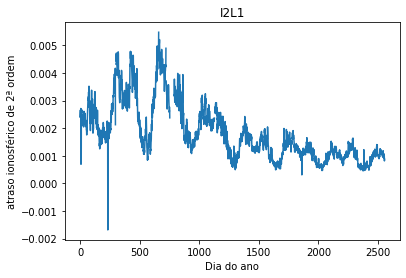

In [45]:
plt.plot(results_I2L1)
plt.title('I2L1')
plt.xlabel('Dia do ano')
plt.ylabel('atraso ionosférico de 2ª ordem')
plt.show()

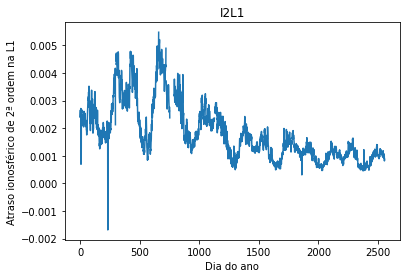

In [46]:
x_axis=np.arange(start_doy,end_doy+1)
plt.plot(results_I2L1)
#plt.xticks(np.arange(start_doy,end_doy+1, 0.5)) #intervalos do eixo x
plt.title('I2L1')
plt.xlabel('Dia do ano')
plt.ylabel('Atraso ionosférico de 2ª ordem na L1')
plt.savefig('results/I2L1.png') #antes do show
plt.show()

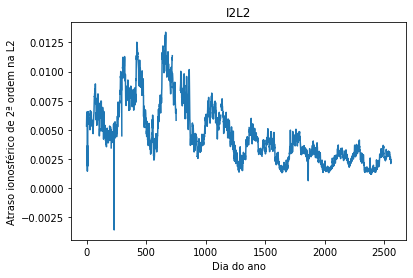

In [47]:
plt.plot(results_I2L2)
plt.title('I2L2')
plt.xlabel('Dia do ano')
plt.ylabel('Atraso ionosférico de 2ª ordem na L2')
plt.show()

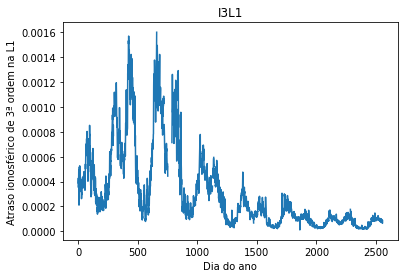

In [48]:
plt.plot(results_I3L1)
plt.title('I3L1')
plt.xlabel('Dia do ano')
plt.ylabel('Atraso ionosférico de 3ª ordem na L1')
plt.show()

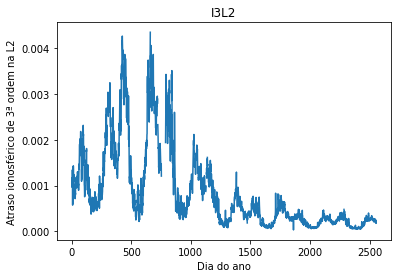

In [49]:
plt.plot(results_I3L2)
plt.title('I3L2')
plt.xlabel('Dia do ano')
plt.ylabel('Atraso ionosférico de 3ª ordem na L2')
plt.show()

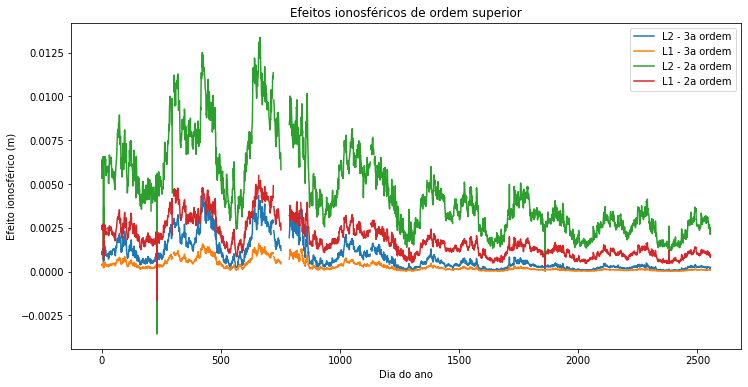

In [50]:
plt.figure(figsize=(12,6))
plt.plot(results_I3L2, label="L2 - 3a ordem")
plt.plot(results_I3L1, label="L1 - 3a ordem")
plt.plot(results_I2L2, label="L2 - 2a ordem")
plt.plot(results_I2L1, label="L1 - 2a ordem")
plt.title('Efeitos ionosféricos de ordem superior')
plt.xlabel('Dia do ano')
plt.ylabel('Efeito ionosférico (m)')
plt.legend()
plt.show()

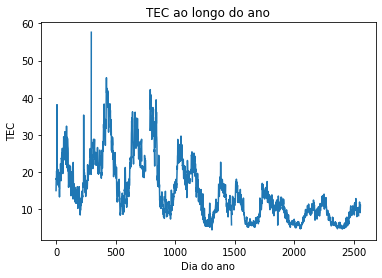

In [51]:
plt.plot(results_tec)
plt.title('TEC ao longo do ano')
plt.xlabel('Dia do ano')
plt.ylabel('TEC')
plt.show()

# Space weather

In [52]:
for year in range (start_year,end_year+1):
  baseurl = f"ftp://ftp.gfz-potsdam.de/pub/home/obs/Kp_ap_Ap_SN_F107/Kp_ap_Ap_SN_F107_{year}.txt"
  os.makedirs("f107",exist_ok=True)
  local_filename = os.path.join("f107",baseurl.split('/')[-1])
  f107_file=local_filename.replace('.gz','')
  print("Downloading ", baseurl)
  !wget $baseurl -O $local_filename
  print("Saved ",local_filename)

--2022-07-20 22:57:41--  ftp://ftp.gfz-potsdam.de/pub/home/obs/Kp_ap_Ap_SN_F107/Kp_ap_Ap_SN_F107_2013.txt
           => ‘f107/Kp_ap_Ap_SN_F107_2013.txt’
Resolving ftp.gfz-potsdam.de (ftp.gfz-potsdam.de)... 139.17.3.3
Connecting to ftp.gfz-potsdam.de (ftp.gfz-potsdam.de)|139.17.3.3|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/pub/home/obs/Kp_ap_Ap_SN_F107 ... done.
==> SIZE Kp_ap_Ap_SN_F107_2013.txt ... 61639
==> PASV ... done.    ==> RETR Kp_ap_Ap_SN_F107_2013.txt ... done.
Length: 61639 (60K) (unauthoritative)

Kp_ap_Ap_SN_F107_20 100%[===================>]  60,19K  57,3KB/s    in 1,0s    

2022-07-20 22:57:46 (57,3 KB/s) - ‘f107/Kp_ap_Ap_SN_F107_2013.txt’ saved [61639]

Saved  f107/Kp_ap_Ap_SN_F107_2013.txt
--2022-07-20 22:57:46--  ftp://ftp.gfz-potsdam.de/pub/home/obs/Kp_ap_Ap_SN_F107/Kp_ap_Ap_SN_F107_2014.txt
           => ‘f107/Kp_ap_Ap_SN_F107_2014.txt’
Resolving ftp.gfz-potsdam.de (ftp.gfz

In [53]:
f107=[]
for year in range (start_year,end_year+1):
  baseurl = f"ftp://ftp.gfz-potsdam.de/pub/home/obs/Kp_ap_Ap_SN_F107/Kp_ap_Ap_SN_F107_{year}.txt"
  os.makedirs("f107",exist_ok=True)
  local_filename = os.path.join("f107",baseurl.split('/')[-1])
  f107_file=local_filename.replace('.gz','')
  df=pd.read_csv(f107_file,comment='#',header=None, delim_whitespace=True)
  fcolumn=df.columns[-2]
  df.loc[df[fcolumn] <= 0, fcolumn] = None
  f107_series=df[fcolumn].replace(-1,None).ffill()
  f107.append(f107_series.to_numpy())
  #print(df[fcolumn].to_numpy())
  #print("Downloading ", baseurl)
  #print("Saved ",local_filename)
f107_concat=np.concatenate(f107)
np.savetxt('results/f107.txt',np.array(f107_concat))


In [54]:
results_f107 = np.loadtxt('results/f107.txt')

# Exporting the table

In [56]:
from datetime import datetime
firstDate=datetime(year=2013, month=1,day=1)
datelist = pd.date_range(firstDate, periods=len(results_I3L2)).tolist()
d={"date": datelist, "I2L1": np.array(results_I2L1),"I2L2": np.array(results_I2L2),"I3L1": np.array(results_I3L1), "I3L2": np.array(results_I3L2), "VTEC": np.array(results_tec), "f107cm": f107_concat}
outdf=pd.DataFrame(data=d)
outdf.to_csv("iono_series.csv")

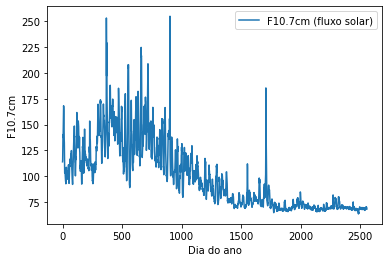

In [57]:
plt.plot(results_f107, label='F10.7cm (fluxo solar)')
plt.xlabel('Dia do ano')
plt.ylabel('F10.7cm')
plt.legend()

In [58]:
results_f107
ind=np.argpartition(results_f107, -5)[-5:]
results_f107[ind]

array([216.8, 224.8, 253.3, 255. , 229.3])

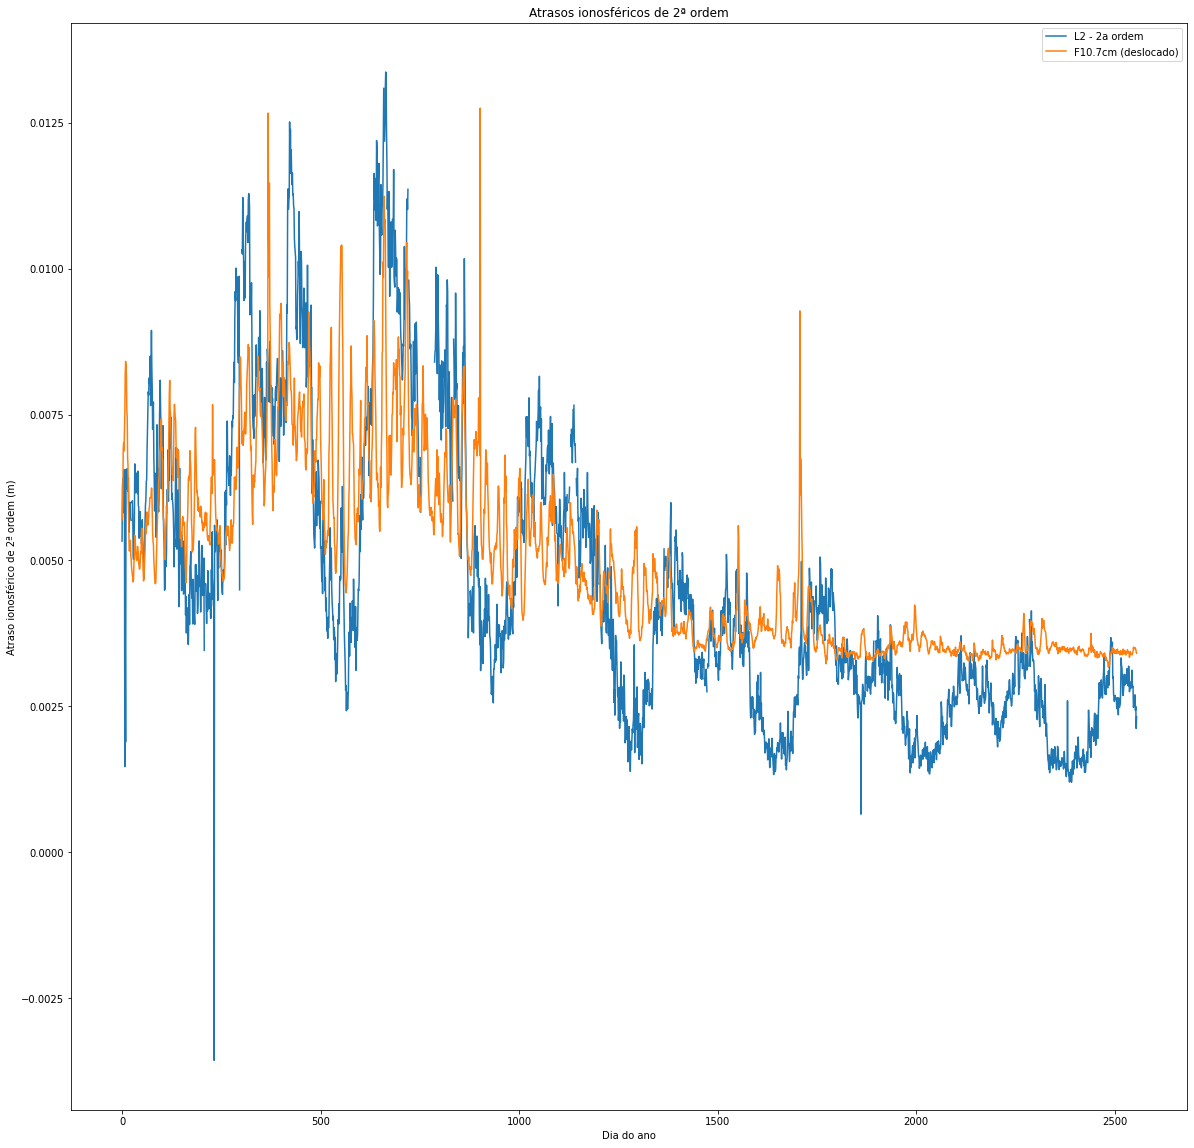

In [59]:
plt.figure(figsize=(20,20))
plt.plot(results_I2L2, label="L2 - 2a ordem")
plt.plot(results_f107/100000.*5, label="F10.7cm (deslocado)")
plt.title('Atrasos ionosféricos de 2ª ordem')
plt.xlabel('Dia do ano')
plt.ylabel('Atraso ionosférico de 2ª ordem (m)')
plt.legend()
plt.show()

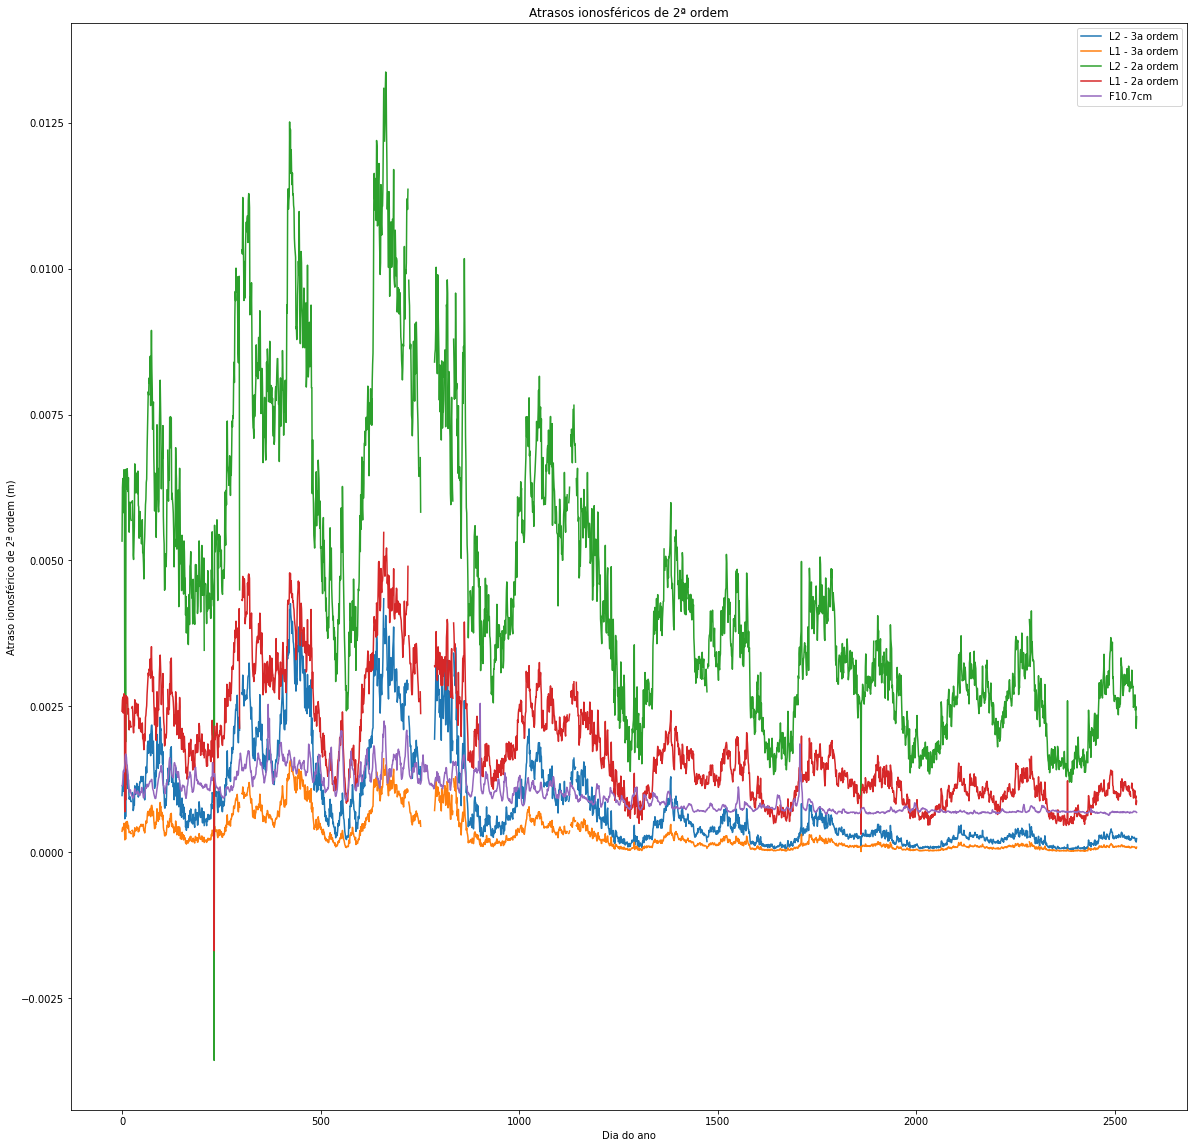

In [60]:
plt.figure(figsize=(20,20))
plt.plot(results_I3L2, label="L2 - 3a ordem")
plt.plot(results_I3L1, label="L1 - 3a ordem")
plt.plot(results_I2L2, label="L2 - 2a ordem")
plt.plot(results_I2L1, label="L1 - 2a ordem")
plt.plot(results_f107/100000., label="F10.7cm")
plt.title('Atrasos ionosféricos de 2ª ordem')
plt.xlabel('Dia do ano')
plt.ylabel('Atraso ionosférico de 2ª ordem (m)')
plt.legend()
plt.show()

In [61]:
outdf.max()

date      2019-12-31 00:00:00
I2L1                  0.00548
I2L2                 0.013369
I3L1                 0.001601
I3L2                 0.004343
VTEC                57.630883
f107cm                  255.0
dtype: object

# Correlação

In [62]:
results_f107.shape
results_I3L2.shape

(2556,)

In [69]:
import scipy.stats
outdf2=outdf.ffill()
print(scipy.stats.pearsonr(results_f107,outdf2[['I3L2']]))
print(scipy.stats.pearsonr(results_f107,outdf2[['I3L1']]))
print(scipy.stats.pearsonr(results_f107,outdf2[['I2L2']]))
print(scipy.stats.pearsonr(results_f107,outdf2[['I2L1']]))
print(scipy.stats.pearsonr(results_f107,outdf2[['VTEC']]))

(array([0.7763467624785455], dtype=object), 0.0)
(array([0.7763466883008537], dtype=object), 0.0)
(array([0.7894018898150212], dtype=object), 0.0)
(array([0.7894621775065026], dtype=object), 0.0)
(array([0.7229658149623301], dtype=object), 0.0)


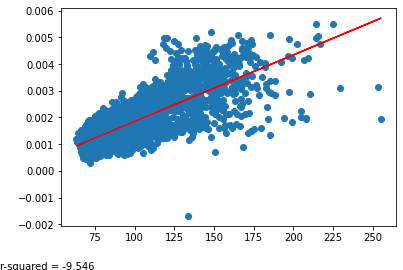

In [70]:
compareSeries=outdf2[['I2L1']]
plt.scatter(results_f107,compareSeries)
plt.annotate("r-squared = {:.3f}".format(r2_score(results_f107, compareSeries)), (0, 1), xycoords='figure points')
y_test, y_predicted = results_f107.reshape(-1,1), np.array(compareSeries).reshape(-1,1)
plt.plot(y_test, LinearRegression().fit(y_test, y_predicted).predict(y_test), color="red")

In [ ]:
outdf.describe()